<a href="https://colab.research.google.com/github/maryamagahi/Playground/blob/main/Project3_ML_Classification_Customer_Satisfaction_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML_Classification_Customer Satisfaction Prediction
* [Context](#1)
* [Import Libraries](#2)
* [Loading the Data](#3)
* [Data Overview](#4)
* [Data Preprocessing - Part1](#5)
* [Exploratory Data Analysis](#6)
* [Data Preprocessing - Part2](#7)
* [Model Evaluation Criterion](#8)
* [Building the Model](#9)
* [Logistic Regression](#9.1)
* [Random Forest](#9.2)
* [Tuned Random Forest](#9.3)
* [LightGBM](#9.4)

<a name="1"></a>
## 1. Context

This problem statement is based on the Shinkansen Bullet Train in Japan, and passengers’ experience with that mode of travel. The on-time performance of the trains along with passenger information is available.  These passengers were later asked to provide their feedback on various parameters related to the travel along with their overall experience.

### Goal:
The goal of the problem is to predict whether a passenger was satisfied or not considering his/her overall experience of travelling on the Shinkansen Bullet Train.

### Dataset:

The problem consists of 2 separate datasets: Travel data & Survey data. Travel data has information related to passengers and attributes related to the Shinkansen train, in which they travelled. The survey data is aggregated data of surveys indicating the post-service experience. You are expected to treat both these datasets as raw data and perform any necessary data cleaning/validation steps as required.


### Evaluation Criteria:

**Accuracy Score:** The evaluation metric is simply the percentage of predictions made by the model that turned out to be correct. This is also called the accuracy of the model. It will be calculated as the total number of correct predictions (True Positives + True Negatives) divided by the total number of observations in the dataset.




<a name="2"></a>
## 2. Import Libraries

In [ ]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# Setting the precision of floating numbers to 5 decimal points
pd.set_option("display.float_format", lambda x: "%.5f" % x)

# To tune model, get different metric scores, and split data
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    precision_recall_curve
)
from sklearn import metrics

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression

# To build classification models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier

# for cross-validation
from sklearn.model_selection import cross_val_score

# For tuning the model
from sklearn.model_selection import GridSearchCV

# To supress warnings
import warnings
warnings.filterwarnings("ignore")
import re



<a name="3"></a>
## 3. Loading the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading Train Survey dataset
Surveydata_train = pd.read_csv("/content/drive/MyDrive/Data Science/Notebooks/Raw Data/Surveydata_train.csv")

In [ ]:
# Loading Train Travel dataset
Traveldata_train = pd.read_csv("/content/drive/MyDrive/Data Science/Notebooks/Raw Data/Traveldata_train.csv")

In [ ]:
# Loading Test Survey dataset
Surveydata_test = pd.read_csv("/content/drive/MyDrive/Data Science/Notebooks/Raw Data/Surveydata_test.csv")

In [ ]:
# Loading Test Travel dataset
Traveldata_test = pd.read_csv("/content/drive/MyDrive/Data Science/Notebooks/Raw Data/Traveldata_test.csv")

In [ ]:
Surveydata1 = Surveydata_train.copy()
Surveydata2 = Surveydata_test.copy()
Traveldata1 = Traveldata_train.copy()
Traveldata2 = Traveldata_test.copy()

<a name="4"></a>
## 4. Data Overview

In [ ]:
# Check if any duplication of data
Traveldata1.duplicated().sum()

0

In [ ]:
# Check if any duplication of data
Surveydata1.duplicated().sum()

0

In [ ]:
# join travel & survey train data
df1=pd.merge(Traveldata1, Surveydata1, on='ID', how='inner')
df1

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,98800001,Female,Loyal Customer,52.00000,NaN,Business,272,0.00000,5.00000,0,Needs Improvement,Green Car,Excellent,Excellent,Very Convenient,Good,Needs Improvement,Acceptable,Needs Improvement,Needs Improvement,Acceptable,Needs Improvement,Good,Needs Improvement,Poor
1,98800002,Male,Loyal Customer,48.00000,Personal Travel,Eco,2200,9.00000,0.00000,0,Poor,Ordinary,Excellent,Poor,Needs Improvement,Good,Poor,Good,Good,Excellent,Needs Improvement,Poor,Needs Improvement,Good,Good
2,98800003,Female,Loyal Customer,43.00000,Business Travel,Business,1061,77.00000,119.00000,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Excellent
3,98800004,Female,Loyal Customer,44.00000,Business Travel,Business,780,13.00000,18.00000,0,Acceptable,Ordinary,Needs Improvement,NaN,Needs Improvement,Acceptable,Needs Improvement,Acceptable,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Acceptable
4,98800005,Female,Loyal Customer,50.00000,Business Travel,Business,1981,0.00000,0.00000,1,Acceptable,Ordinary,Acceptable,Acceptable,Manageable,Needs Improvement,Good,Excellent,Good,Good,Good,Good,Good,Good,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94374,98894375,Male,Loyal Customer,32.00000,Business Travel,Business,1357,83.00000,125.00000,0,Poor,Ordinary,Good,Good,Convenient,Poor,Poor,Poor,Poor,Good,Good,Good,Needs Improvement,Good,Poor
94375,98894376,Male,Loyal Customer,44.00000,Business Travel,Business,592,5.00000,11.00000,1,Good,Ordinary,Good,Good,Convenient,Needs Improvement,Excellent,Excellent,Acceptable,Acceptable,Acceptable,Acceptable,Good,Acceptable,Good
94376,98894377,Male,NaN,63.00000,Business Travel,Business,2794,0.00000,0.00000,1,Needs Improvement,Green Car,Needs Improvement,Needs Improvement,Needs Improvement,Good,Excellent,Good,Good,Good,Good,Good,Acceptable,Good,Acceptable
94377,98894378,Male,Loyal Customer,16.00000,Personal Travel,Eco,2744,0.00000,0.00000,0,Needs Improvement,Ordinary,NaN,Needs Improvement,Convenient,Good,Needs Improvement,Good,Good,Acceptable,Good,Good,Good,Excellent,Good


In [ ]:
# Check the data types of each coloumn for train data
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94379 entries, 0 to 94378
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       94379 non-null  int64  
 1   Gender                   94302 non-null  object 
 2   Customer_Type            85428 non-null  object 
 3   Age                      94346 non-null  float64
 4   Type_Travel              85153 non-null  object 
 5   Travel_Class             94379 non-null  object 
 6   Travel_Distance          94379 non-null  int64  
 7   Departure_Delay_in_Mins  94322 non-null  float64
 8   Arrival_Delay_in_Mins    94022 non-null  float64
 9   Overall_Experience       94379 non-null  int64  
 10  Seat_Comfort             94318 non-null  object 
 11  Seat_Class               94379 non-null  object 
 12  Arrival_Time_Convenient  85449 non-null  object 
 13  Catering                 85638 non-null  object 
 14  Platform_Location     

In [ ]:
# Review statistical summary of the train data
df1.describe()

,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience
count,94379.00000,94346.00000,94379.00000,94322.00000,94022.00000,94379.00000
mean,98847190.00000,39.41965,1978.88818,14.64709,15.00522,0.54666
std,27245.01487,15.11663,1027.96102,38.13878,38.43941,0.49782
min,98800001.00000,7.00000,50.00000,0.00000,0.00000,0.00000
25%,98823595.50000,27.00000,1359.00000,0.00000,0.00000,0.00000
50%,98847190.00000,40.00000,1923.00000,0.00000,0.00000,1.00000
75%,98870784.50000,51.00000,2538.00000,12.00000,13.00000,1.00000
max,98894379.00000,85.00000,6951.00000,1592.00000,1584.00000,1.00000


In [ ]:
# Let's check for missing values in the train data
round(df1.isnull().sum() / df1.isnull().count() * 100, 2)

ID                        0.00000
Gender                    0.08000
Customer_Type             9.48000
Age                       0.03000
Type_Travel               9.78000
Travel_Class              0.00000
Travel_Distance           0.00000
Departure_Delay_in_Mins   0.06000
Arrival_Delay_in_Mins     0.38000
Overall_Experience        0.00000
Seat_Comfort              0.06000
Seat_Class                0.00000
Arrival_Time_Convenient   9.46000
Catering                  9.26000
Platform_Location         0.03000
Onboard_Wifi_Service      0.03000
Onboard_Entertainment     0.02000
Online_Support            0.10000
Ease_of_Online_Booking    0.08000
Onboard_Service           8.05000
Legroom                   0.10000
Baggage_Handling          0.15000
CheckIn_Service           0.08000
Cleanliness               0.01000
Online_Boarding           0.01000
dtype: float64

In [ ]:
# Check number of unique values by column for train data
df1.nunique()

ID                         94379
Gender                         2
Customer_Type                  2
Age                           75
Type_Travel                    2
Travel_Class                   2
Travel_Distance             5210
Departure_Delay_in_Mins      437
Arrival_Delay_in_Mins        434
Overall_Experience             2
Seat_Comfort                   6
Seat_Class                     2
Arrival_Time_Convenient        6
Catering                       6
Platform_Location              6
Onboard_Wifi_Service           6
Onboard_Entertainment          6
Online_Support                 6
Ease_of_Online_Booking         6
Onboard_Service                6
Legroom                        6
Baggage_Handling               5
CheckIn_Service                6
Cleanliness                    6
Online_Boarding                6
dtype: int64

In [ ]:
# Making a list of all categorical variables for train data
cat_col = list(df1.select_dtypes("object").columns)

# Printing the count of each unique value
for column in cat_col:
    print(df1[column].value_counts())
    print("-" * 50)

Female    47815
Male      46487
Name: Gender, dtype: int64
--------------------------------------------------
Loyal Customer       69823
Disloyal Customer    15605
Name: Customer_Type, dtype: int64
--------------------------------------------------
Business Travel    58617
Personal Travel    26536
Name: Type_Travel, dtype: int64
--------------------------------------------------
Eco         49342
Business    45037
Name: Travel_Class, dtype: int64
--------------------------------------------------
Acceptable           21158
Needs Improvement    20946
Good                 20595
Poor                 15185
Excellent            12971
Extremely Poor        3463
Name: Seat_Comfort, dtype: int64
--------------------------------------------------
Green Car    47435
Ordinary     46944
Name: Seat_Class, dtype: int64
--------------------------------------------------
Good                 19574
Excellent            17684
Acceptable           15177
Needs Improvement    14990
Poor                 136

In [ ]:
# join travel & survey test data
df2=pd.merge(Traveldata2, Surveydata2, on='ID', how='inner')
df2

,ID,Gender,Customer_Type,Age,Type_Travel,Travel_Class,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Seat_Comfort,Seat_Class,Arrival_Time_Convenient,Catering,Platform_Location,Onboard_Wifi_Service,Onboard_Entertainment,Online_Support,Ease_of_Online_Booking,Onboard_Service,Legroom,Baggage_Handling,CheckIn_Service,Cleanliness,Online_Boarding
0,99900001,Female,NaN,36.00000,Business Travel,Business,532,0.00000,0.00000,Acceptable,Green Car,Acceptable,Acceptable,Manageable,Needs Improvement,Excellent,Good,Excellent,Excellent,Excellent,Excellent,Good,Excellent,Poor
1,99900002,Female,Disloyal Customer,21.00000,Business Travel,Business,1425,9.00000,28.00000,Extremely Poor,Ordinary,Good,Poor,Manageable,Acceptable,Poor,Acceptable,Acceptable,Excellent,Acceptable,Good,Acceptable,Excellent,Acceptable
2,99900003,Male,Loyal Customer,60.00000,Business Travel,Business,2832,0.00000,0.00000,Excellent,Ordinary,Excellent,Excellent,Very Convenient,Excellent,Excellent,Excellent,Needs Improvement,Needs Improvement,Needs Improvement,Needs Improvement,Good,Needs Improvement,Excellent
3,99900004,Female,Loyal Customer,29.00000,Personal Travel,Eco,1352,0.00000,0.00000,Acceptable,Green Car,Excellent,Acceptable,Very Convenient,Poor,Acceptable,Excellent,Poor,Acceptable,Needs Improvement,Excellent,Excellent,Excellent,Poor
4,99900005,Male,Disloyal Customer,18.00000,Business Travel,Business,1610,17.00000,0.00000,Excellent,Ordinary,Extremely Poor,Excellent,Needs Improvement,Excellent,Excellent,Excellent,Excellent,NaN,Acceptable,Excellent,Excellent,Excellent,Excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,99935598,Male,Loyal Customer,8.00000,Personal Travel,Eco,1334,0.00000,0.00000,Needs Improvement,Green Car,Excellent,Needs Improvement,Manageable,Acceptable,Needs Improvement,Acceptable,Acceptable,Good,Excellent,Good,Acceptable,Good,Acceptable
35598,99935599,Female,Loyal Customer,53.00000,Business Travel,Business,1772,0.00000,0.00000,Needs Improvement,Ordinary,Needs Improvement,Good,Needs Improvement,Acceptable,Excellent,Excellent,Good,Good,Good,Good,Acceptable,Good,Good
35599,99935600,Male,Disloyal Customer,22.00000,Business Travel,Eco,1180,0.00000,0.00000,Good,Green Car,Extremely Poor,Good,Needs Improvement,Needs Improvement,Good,Poor,Needs Improvement,Poor,Acceptable,Poor,Poor,Excellent,Needs Improvement
35600,99935601,Female,Loyal Customer,67.00000,Personal Travel,Eco,420,23.00000,16.00000,Excellent,Ordinary,Excellent,Excellent,Inconvenient,Acceptable,Excellent,Good,Excellent,Excellent,Excellent,Excellent,Acceptable,Excellent,Good


In [ ]:
# Check the data types of each coloumn for test data
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35602 entries, 0 to 35601
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       35602 non-null  int64  
 1   Gender                   35572 non-null  object 
 2   Customer_Type            32219 non-null  object 
 3   Age                      35591 non-null  float64
 4   Type_Travel              32154 non-null  object 
 5   Travel_Class             35602 non-null  object 
 6   Travel_Distance          35602 non-null  int64  
 7   Departure_Delay_in_Mins  35573 non-null  float64
 8   Arrival_Delay_in_Mins    35479 non-null  float64
 9   Seat_Comfort             35580 non-null  object 
 10  Seat_Class               35602 non-null  object 
 11  Arrival_Time_Convenient  32277 non-null  object 
 12  Catering                 32245 non-null  object 
 13  Platform_Location        35590 non-null  object 
 14  Onboard_Wifi_Service  

In [ ]:
# Review statistical summary of the test data
df2.describe()

,ID,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins
count,35602.00000,35591.00000,35602.00000,35573.00000,35479.00000
mean,99917801.50000,39.44700,1987.15176,14.88070,15.30880
std,10277.55648,15.13755,1024.30886,37.89545,38.53129
min,99900001.00000,7.00000,50.00000,0.00000,0.00000
25%,99908901.25000,27.00000,1360.00000,0.00000,0.00000
50%,99917801.50000,40.00000,1929.00000,0.00000,0.00000
75%,99926701.75000,51.00000,2559.00000,13.00000,13.00000
max,99935602.00000,85.00000,6868.00000,978.00000,970.00000


In [ ]:
# Let's check for missing values in the test data
round(df2.isnull().sum() / df2.isnull().count() * 100, 2)

ID                        0.00000
Gender                    0.08000
Customer_Type             9.50000
Age                       0.03000
Type_Travel               9.68000
Travel_Class              0.00000
Travel_Distance           0.00000
Departure_Delay_in_Mins   0.08000
Arrival_Delay_in_Mins     0.35000
Seat_Comfort              0.06000
Seat_Class                0.00000
Arrival_Time_Convenient   9.34000
Catering                  9.43000
Platform_Location         0.03000
Onboard_Wifi_Service      0.03000
Onboard_Entertainment     0.02000
Online_Support            0.07000
Ease_of_Online_Booking    0.05000
Onboard_Service           8.07000
Legroom                   0.07000
Baggage_Handling          0.11000
CheckIn_Service           0.06000
Cleanliness               0.01000
Online_Boarding           0.01000
dtype: float64

In [ ]:
# Check number of unique values by column for test data
df2.nunique()

ID                         35602
Gender                         2
Customer_Type                  2
Age                           75
Type_Travel                    2
Travel_Class                   2
Travel_Distance             4644
Departure_Delay_in_Mins      350
Arrival_Delay_in_Mins        355
Seat_Comfort                   6
Seat_Class                     2
Arrival_Time_Convenient        6
Catering                       6
Platform_Location              5
Onboard_Wifi_Service           6
Onboard_Entertainment          6
Online_Support                 5
Ease_of_Online_Booking         6
Onboard_Service                5
Legroom                        6
Baggage_Handling               5
CheckIn_Service                5
Cleanliness                    5
Online_Boarding                6
dtype: int64

<a name="5"></a>
## 5. Data Preprocessing - Part1

In [ ]:
# Dropping ID columns for train and test
df1.drop(["ID"], axis=1, inplace=True)
df2.drop(["ID"], axis=1, inplace=True)

In [ ]:
# Reclassifying rare class to closest class for train data
df1['Platform_Location']=np.where(df1['Platform_Location']=='Very Inconvenient', 'Inconvenient', df1['Platform_Location'])
df1['Online_Support']=np.where(df1['Online_Support']=='Extremely Poor', 'Poor', df1['Online_Support'])
df1['Onboard_Service']=np.where(df1['Onboard_Service']=='Extremely Poor', 'Poor', df1['Onboard_Service'])
df1['Cleanliness']=np.where(df1['Cleanliness']=='Extremely Poor', 'Poor', df1['Cleanliness'])
df1['CheckIn_Service']=np.where(df1['CheckIn_Service']=='Extremely Poor', 'Poor', df1['CheckIn_Service'])

In [ ]:
# Making a list of all categorical variables
cat_col = list(df1.select_dtypes("object").columns)

# Printing the count of each unique value
for column in cat_col:
    print(df1[column].value_counts())
    print("-" * 50)

Female    47815
Male      46487
Name: Gender, dtype: int64
--------------------------------------------------
Loyal Customer       69823
Disloyal Customer    15605
Name: Customer_Type, dtype: int64
--------------------------------------------------
Business Travel    58617
Personal Travel    26536
Name: Type_Travel, dtype: int64
--------------------------------------------------
Eco         49342
Business    45037
Name: Travel_Class, dtype: int64
--------------------------------------------------
Acceptable           21158
Needs Improvement    20946
Good                 20595
Poor                 15185
Excellent            12971
Extremely Poor        3463
Name: Seat_Comfort, dtype: int64
--------------------------------------------------
Green Car    47435
Ordinary     46944
Name: Seat_Class, dtype: int64
--------------------------------------------------
Good                 19574
Excellent            17684
Acceptable           15177
Needs Improvement    14990
Poor                 136

In [ ]:
# Making a list of all categorical variables
cat_col = list(df2.select_dtypes("object").columns)

# Printing the count of each unique value
for column in cat_col:
    print(df2[column].value_counts())
    print("-" * 50)

Female    18069
Male      17503
Name: Gender, dtype: int64
--------------------------------------------------
Loyal Customer       26349
Disloyal Customer     5870
Name: Customer_Type, dtype: int64
--------------------------------------------------
Business Travel    22313
Personal Travel     9841
Name: Type_Travel, dtype: int64
--------------------------------------------------
Eco         18473
Business    17129
Name: Travel_Class, dtype: int64
--------------------------------------------------
Acceptable           8003
Needs Improvement    7831
Good                 7808
Poor                 5755
Excellent            4854
Extremely Poor       1329
Name: Seat_Comfort, dtype: int64
--------------------------------------------------
Ordinary     17860
Green Car    17742
Name: Seat_Class, dtype: int64
--------------------------------------------------
Good                 7361
Excellent            6589
Acceptable           5844
Needs Improvement    5684
Poor                 5131
Extremel

In [ ]:
train=df1.copy()

In [ ]:
test=df2.copy()

<a name="6"></a>
## 6. Exploratory Data Analysis

### Univariate Analysis

#### Age

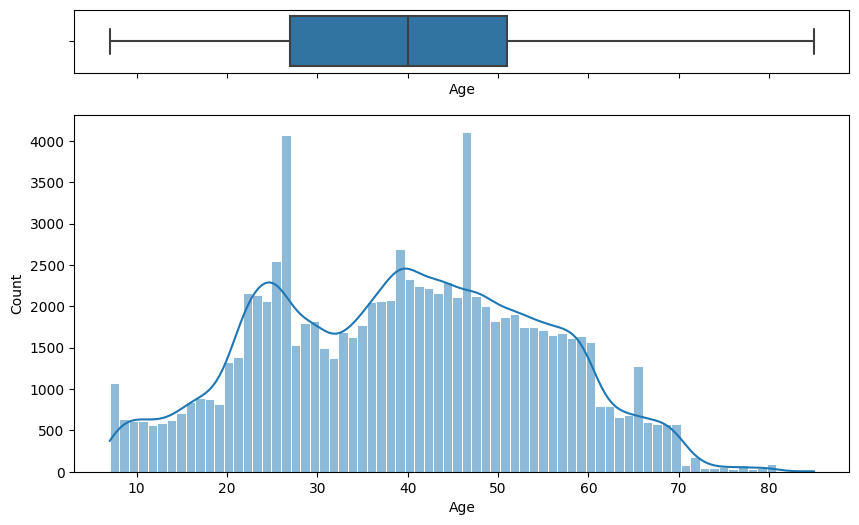

In [ ]:
# create two subplots and stores them in the variables `f` and `(ax_box, ax_hist)`
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)}, figsize=(10, 6))
sns.set_style("darkgrid")

# Add a graph in each part
sns.boxplot(data=train, x="Age", ax=ax_box)
sns.histplot(data=train, x="Age", kde=True, ax=ax_hist)
ax_box.set(xlabel='Age')

plt.show()

#### Travel Distance

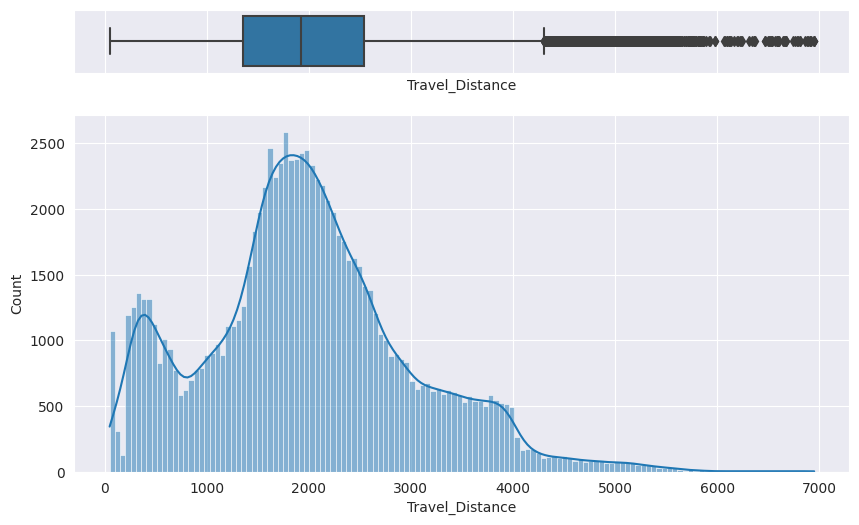

In [ ]:
# create two subplots and stores them in the variables `f` and `(ax_box, ax_hist)`
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)}, figsize=(10, 6))
sns.set_style("darkgrid")

# Add a graph in each part
sns.boxplot(data=train, x="Travel_Distance", ax=ax_box)
sns.histplot(data=train, x="Travel_Distance", kde=True, ax=ax_hist)
ax_box.set(xlabel='Travel_Distance')

plt.show()

#### Departure_Delay_in_Mins

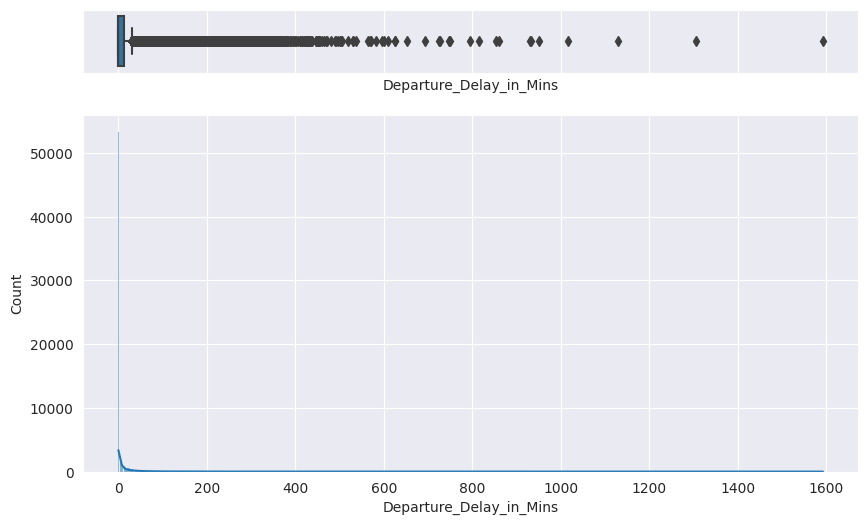

In [ ]:
# create two subplots and stores them in the variables `f` and `(ax_box, ax_hist)`
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)}, figsize=(10, 6))
sns.set_style("darkgrid")

# Add a graph in each part
sns.boxplot(data=train, x="Departure_Delay_in_Mins", ax=ax_box)
sns.histplot(data=train, x="Departure_Delay_in_Mins", kde=True, ax=ax_hist)
ax_box.set(xlabel='Departure_Delay_in_Mins')

plt.show()

#### Arrival_Delay_in_Mins

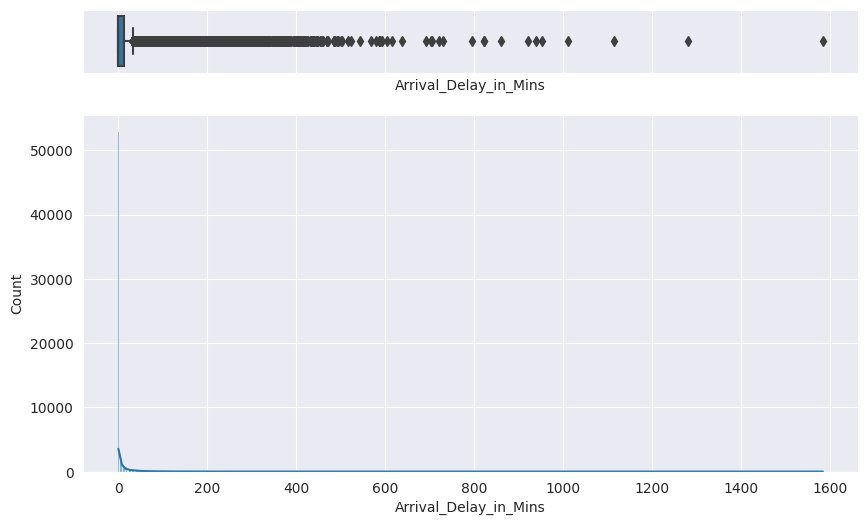

In [ ]:
# create two subplots and stores them in the variables `f` and `(ax_box, ax_hist)`
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)}, figsize=(10, 6))
sns.set_style("darkgrid")

# Add a graph in each part
sns.boxplot(data=train, x="Arrival_Delay_in_Mins", ax=ax_box)
sns.histplot(data=train, x="Arrival_Delay_in_Mins", kde=True, ax=ax_hist)
ax_box.set(xlabel='Arrival_Delay_in_Mins')

plt.show()

In [ ]:
# Function to create labeled barplots

def labeled_barplot(data, feature, perc = False, n = None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])            # Length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize = (count + 1, 5))
    else:
        plt.figure(figsize = (n + 1, 5))

    plt.xticks(rotation = 90, fontsize = 15)
    ax = sns.countplot(
        data = data,
        x = feature,
        palette = "Paired",
        order = data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )                              # Percentage of each class of the category
        else:
            label = p.get_height()         # Count of each level of the category

        x = p.get_x() + p.get_width() / 2  # Width of the plot
        y = p.get_height()                 # Height of the plot

        ax.annotate(
            label,
            (x, y),
            ha = "center",
            va = "center",
            size = 12,
            xytext = (0, 5),
            textcoords = "offset points",
        )                                 # Annotate the percentage

    plt.show()                            # Show the plot

#### Gender

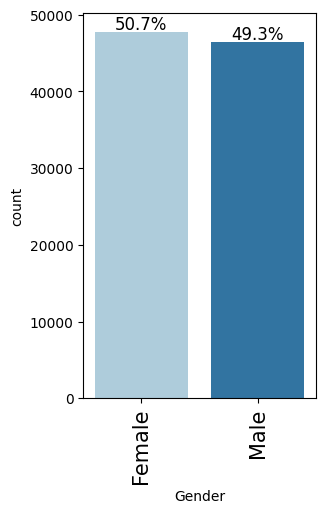

In [ ]:
labeled_barplot(train, "Gender", perc = True)

#### Customer_Type

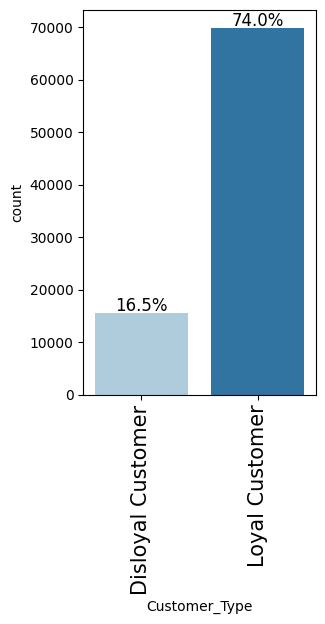

In [ ]:
labeled_barplot(train, "Customer_Type", perc = True)

#### Type_Travel

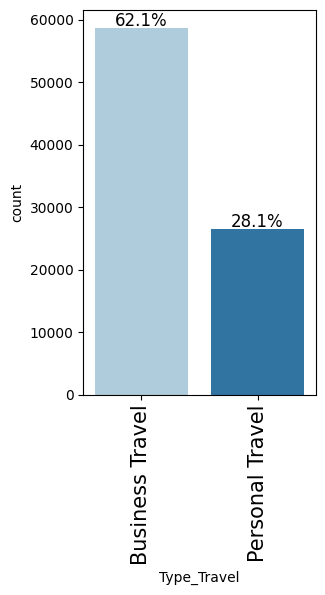

In [ ]:
labeled_barplot(train, "Type_Travel", perc = True)

#### Travel_Class

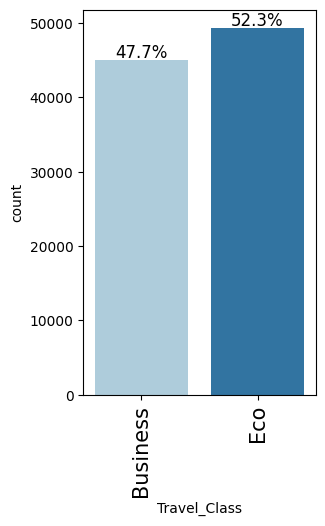

In [ ]:
labeled_barplot(train, "Travel_Class", perc = True)

#### Seat_Comfort

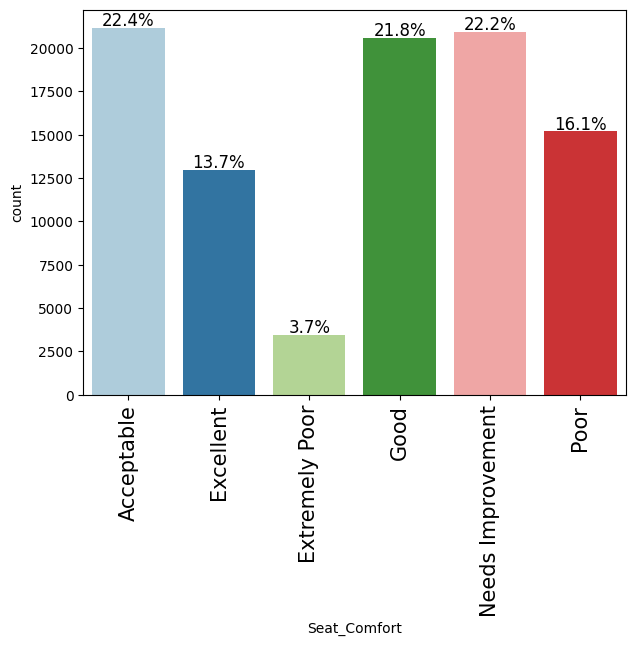

In [ ]:
labeled_barplot(train, "Seat_Comfort", perc = True)

#### Seat_Class

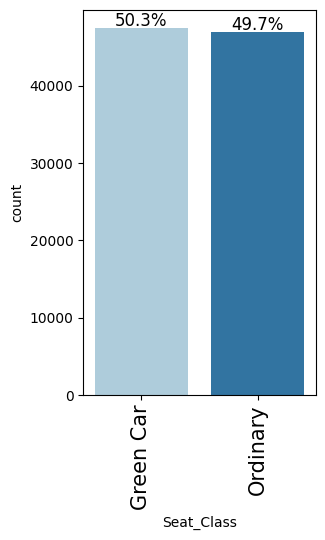

In [ ]:
labeled_barplot(train, "Seat_Class", perc = True)

#### Arrival_Time_Convenient




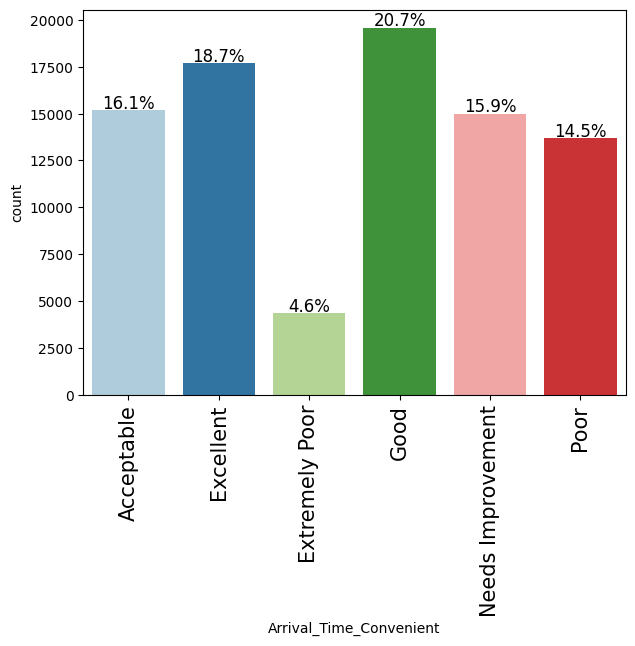

In [ ]:
labeled_barplot(train, "Arrival_Time_Convenient", perc = True)

#### Catering

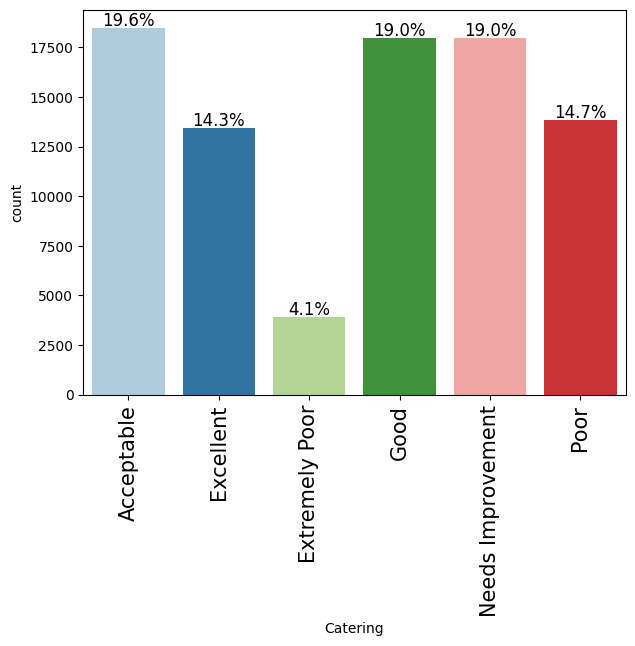

In [ ]:
labeled_barplot(train, "Catering", perc = True)

#### Platform Location

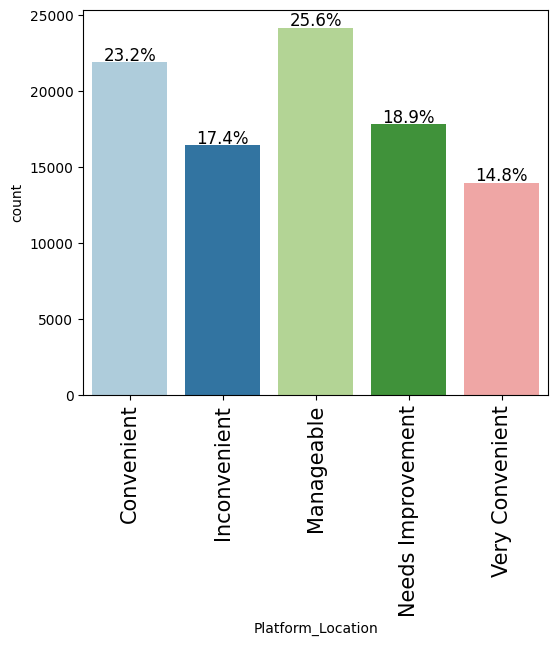

In [ ]:
labeled_barplot(train, "Platform_Location", perc = True)

#### Onboard_Wifi_Service

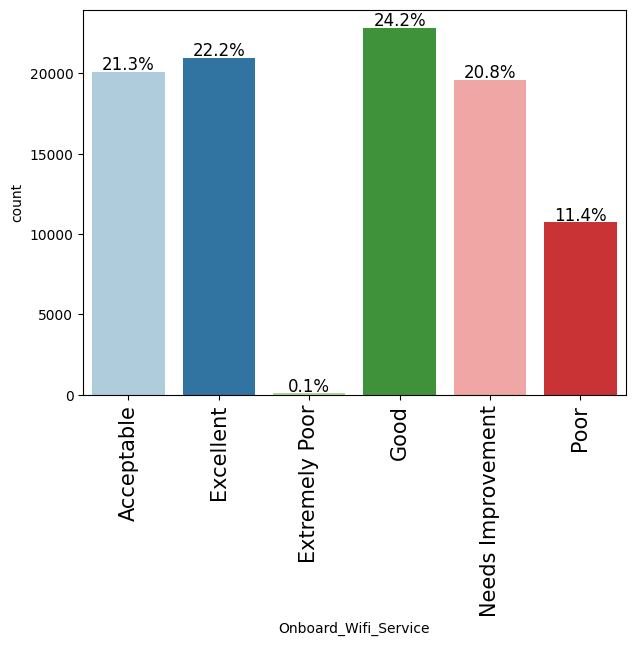

In [ ]:
labeled_barplot(train, "Onboard_Wifi_Service", perc = True)

#### Onboard_Entertainment

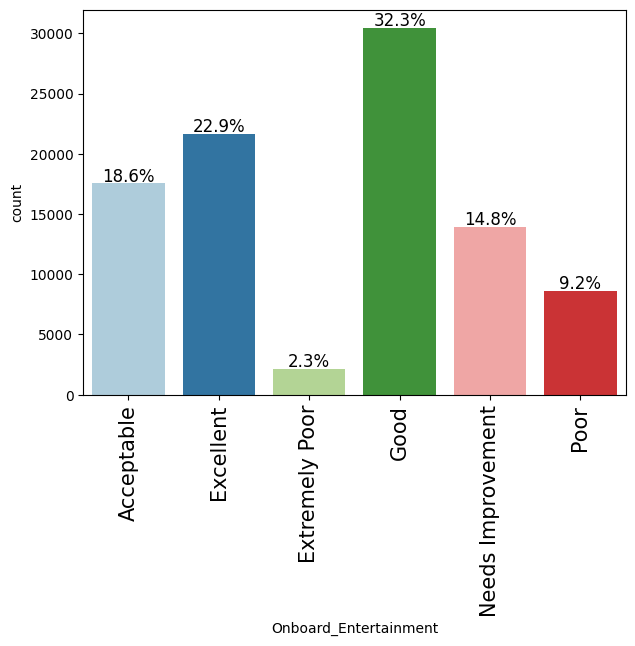

In [ ]:
labeled_barplot(train, "Onboard_Entertainment", perc = True)

#### Online_Support

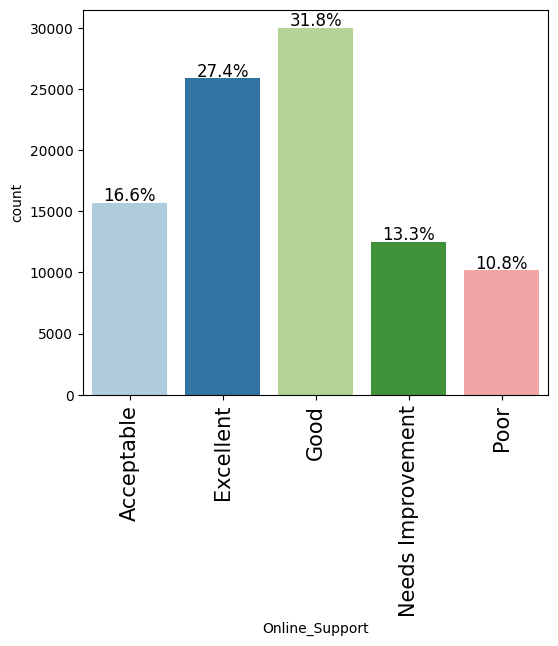

In [ ]:
labeled_barplot(train, "Online_Support", perc = True)

#### Ease_of_Online_Booking

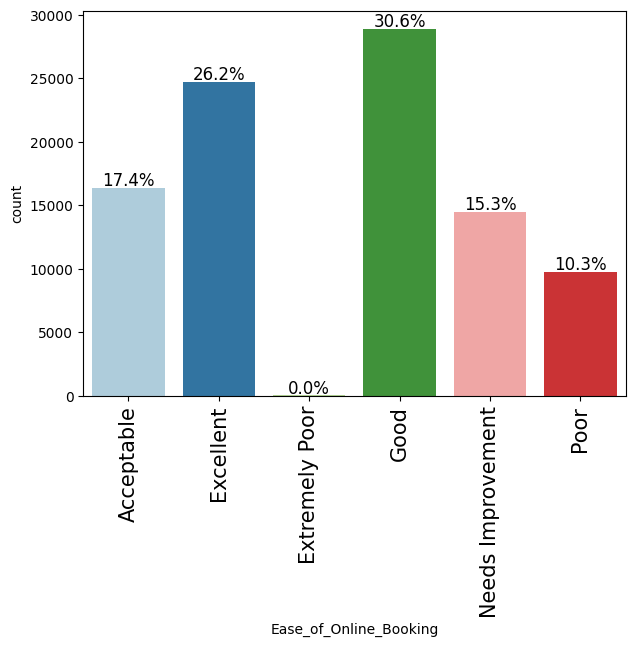

In [ ]:
labeled_barplot(train, "Ease_of_Online_Booking", perc = True)

#### Onboard_Service

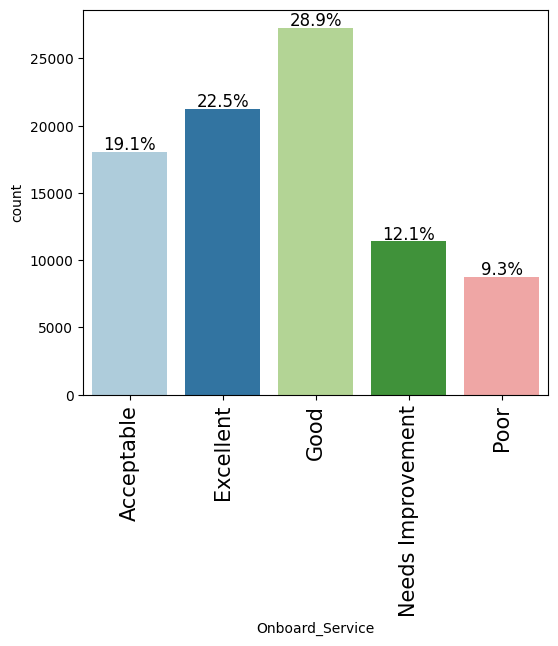

In [ ]:
labeled_barplot(train, "Onboard_Service", perc = True)

#### Legroom

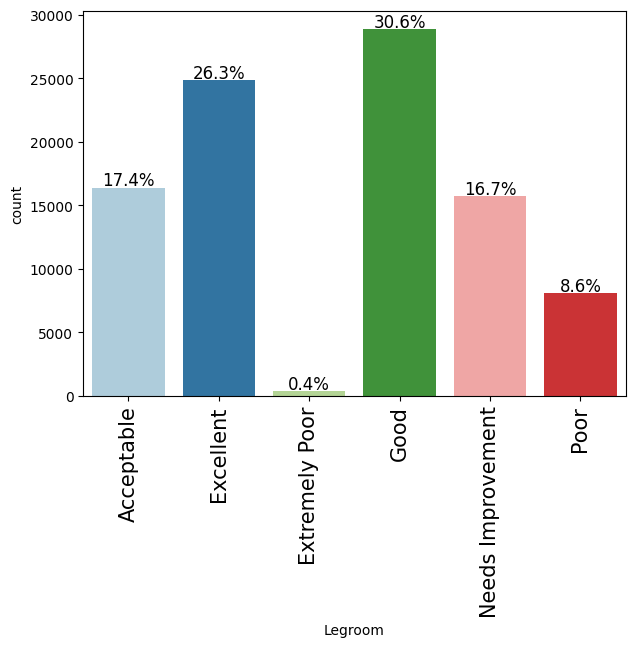

In [ ]:
labeled_barplot(train, "Legroom", perc = True)

#### Baggage_Handling

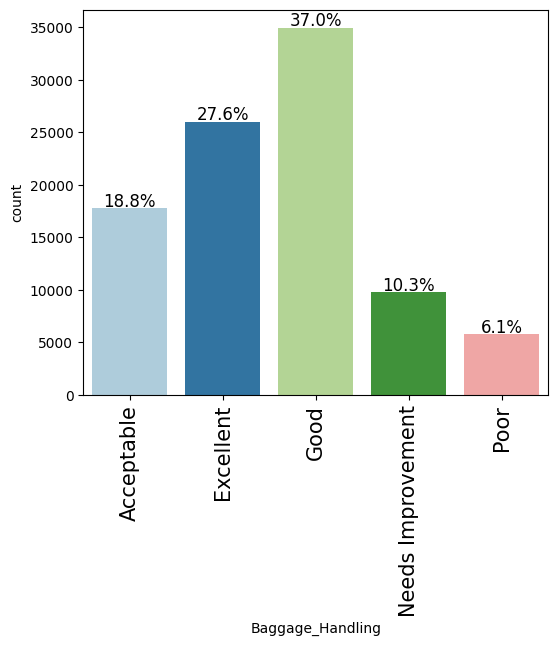

In [ ]:
labeled_barplot(train, "Baggage_Handling", perc = True)

#### CheckIn_Service

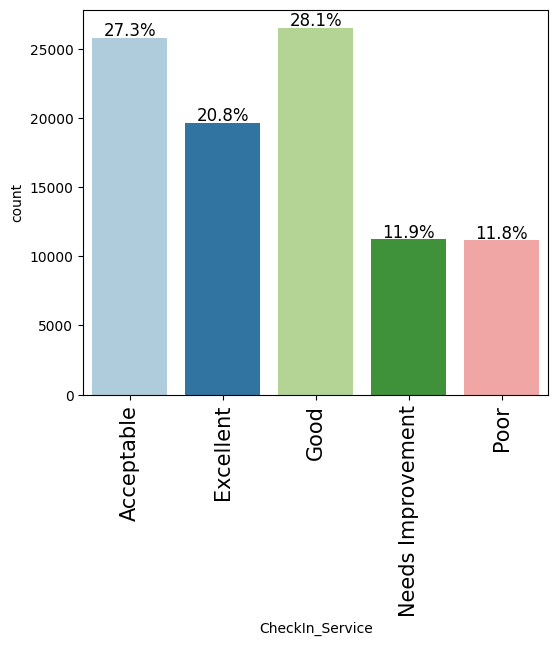

In [ ]:
labeled_barplot(train, "CheckIn_Service", perc = True)

#### Cleanliness

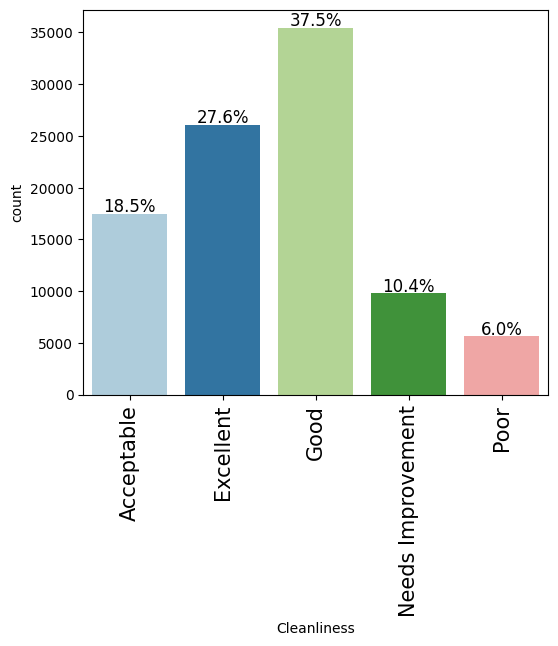

In [ ]:
labeled_barplot(train, "Cleanliness", perc = True)

#### Online_Boarding

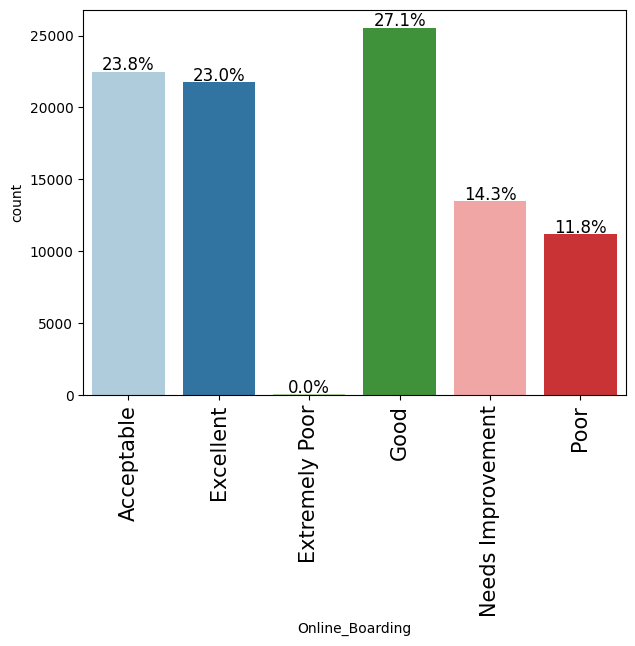

In [ ]:
labeled_barplot(train, "Online_Boarding", perc = True)

### Bivariate Analysis

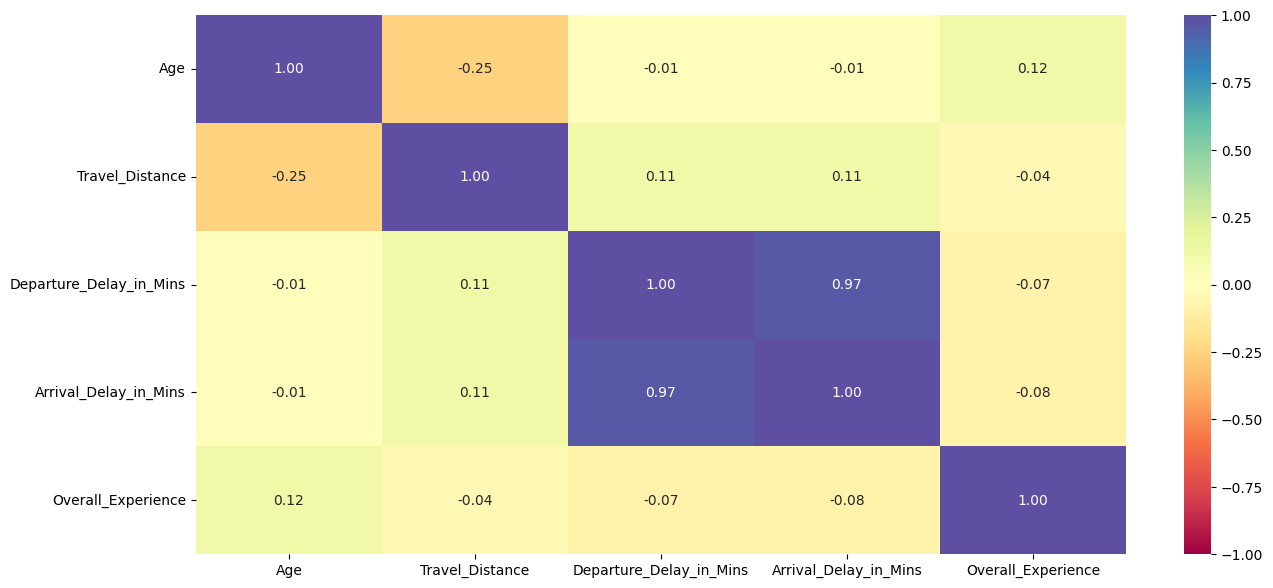

In [ ]:
# Check for relationship between target variable(Overall Experience) and continous variables(age, travel distance, departure delay, arrival delay)
plt.figure(figsize=(15, 7))
sns.heatmap(train.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

Text(0, 0.5, 'Overall Experience %')

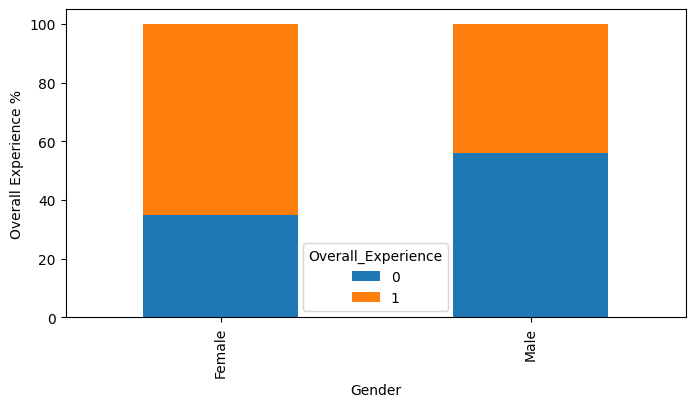

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Gender)
 (pd.crosstab(train['Gender'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

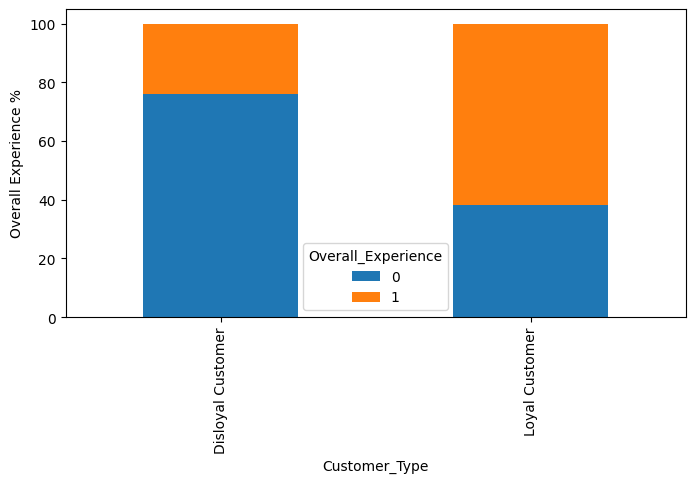

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Customer Type)
 (pd.crosstab(train['Customer_Type'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

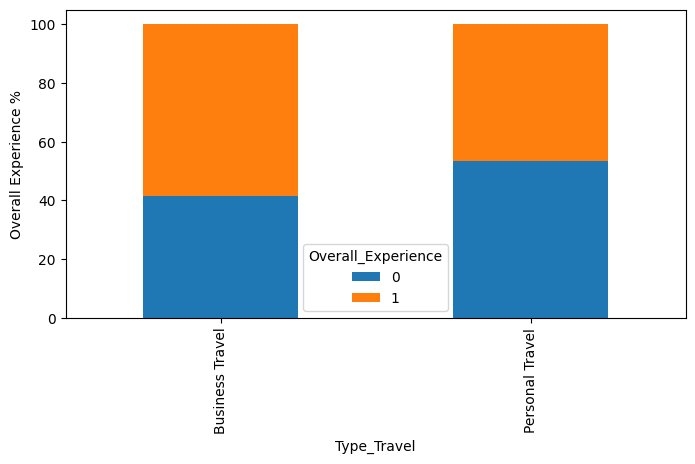

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Travel Type)
(pd.crosstab(train['Type_Travel'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

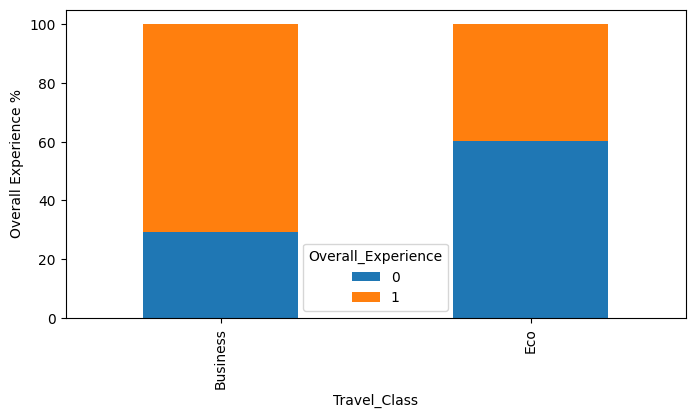

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Travel Class)
 (pd.crosstab(train['Travel_Class'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

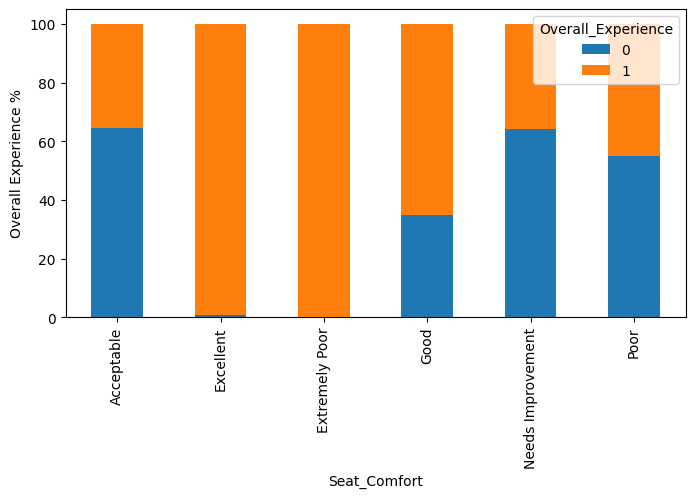

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Seat Comfort)
 (pd.crosstab(train['Seat_Comfort'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

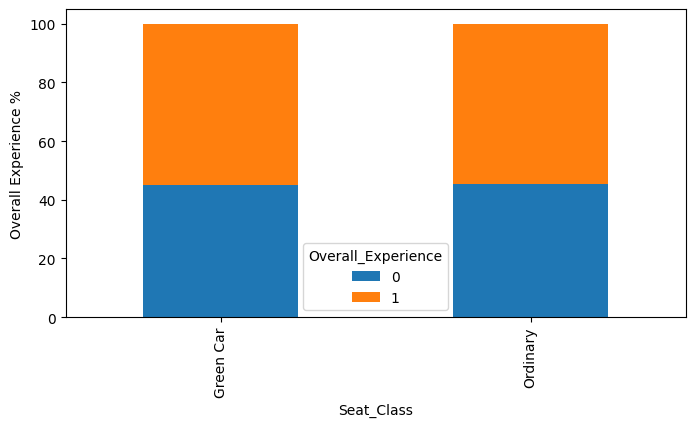

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Seat Class)
 (pd.crosstab(train['Seat_Class'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

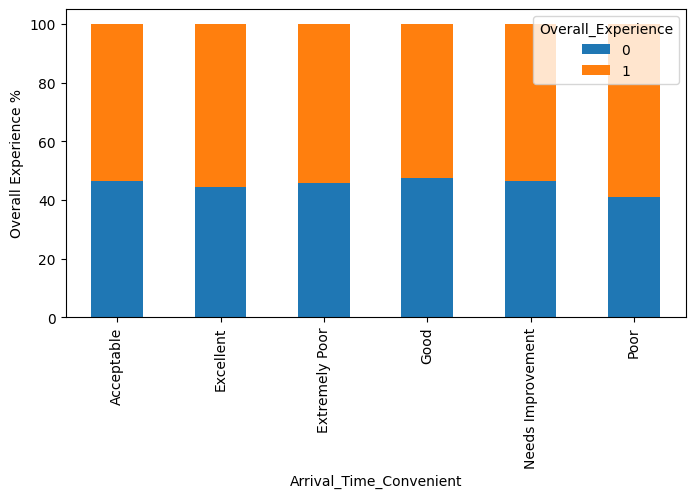

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Arrival Time Convinient)
 (pd.crosstab(train['Arrival_Time_Convenient'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

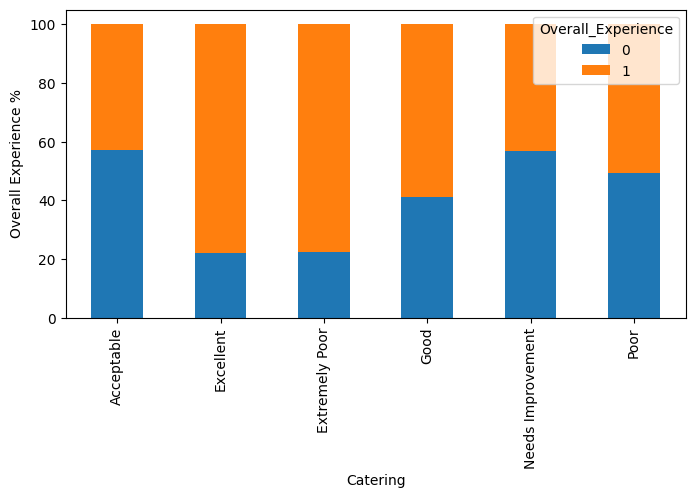

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Catering Experience)
 (pd.crosstab(train['Catering'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

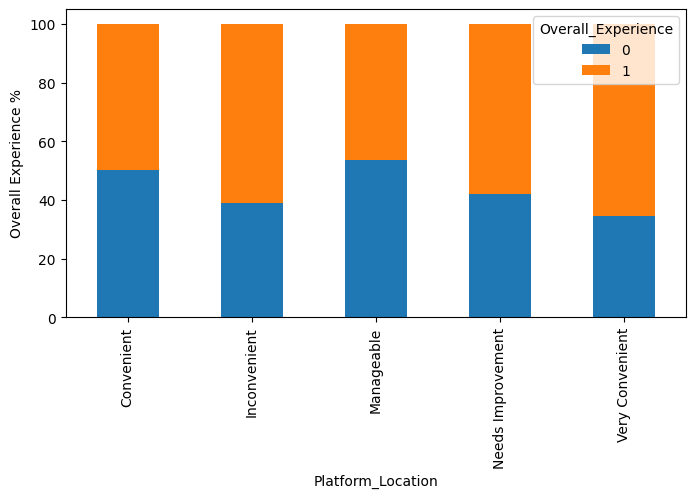

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Platform Location)
 (pd.crosstab(train['Platform_Location'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

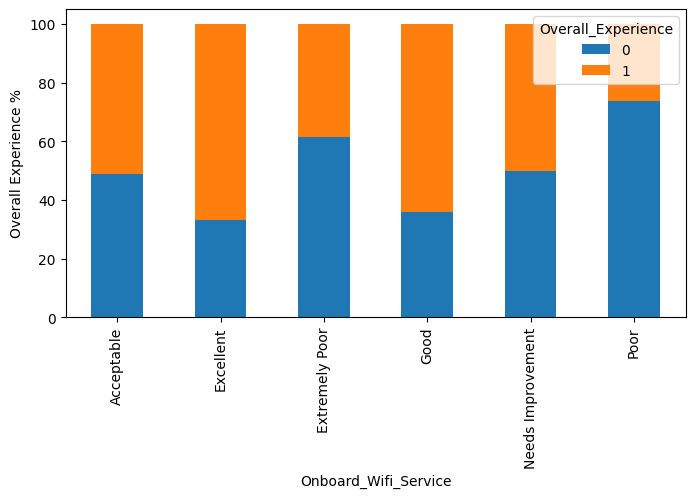

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Wifi)
 (pd.crosstab(train['Onboard_Wifi_Service'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

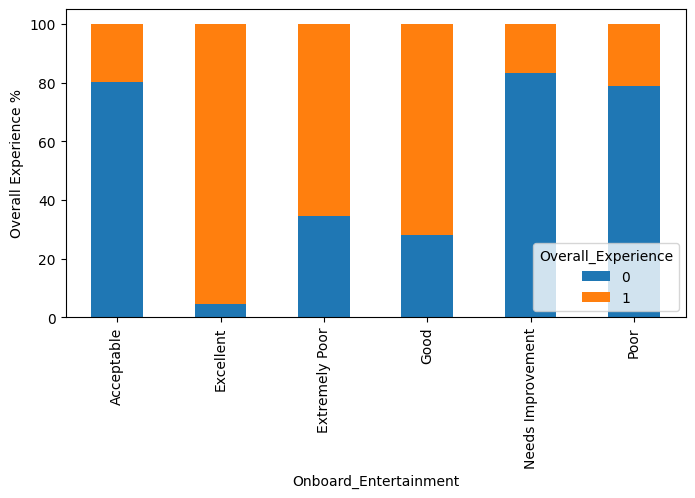

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Onboard Entertainment)
 (pd.crosstab(train['Onboard_Entertainment'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

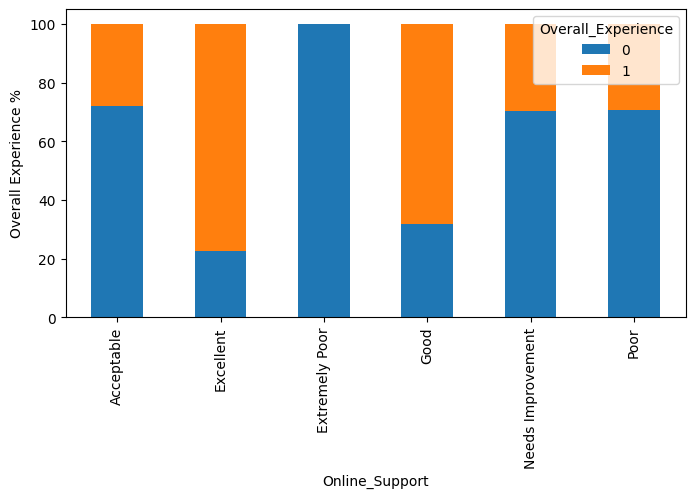

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Online Support)
 (pd.crosstab(train['Online_Support'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

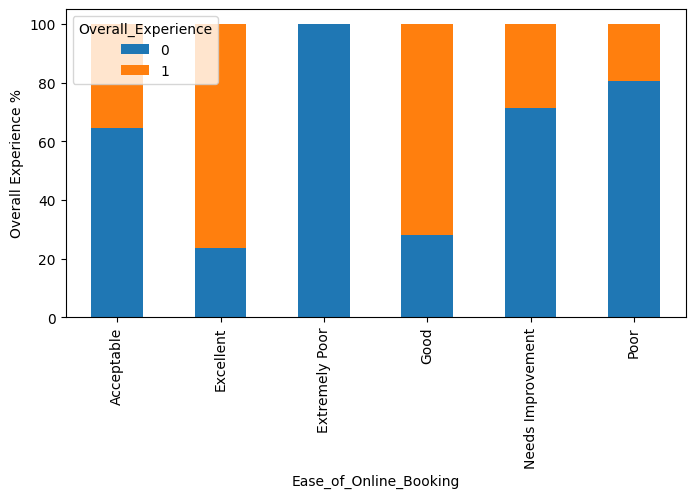

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Ease of Online Booking)
  (pd.crosstab(train['Ease_of_Online_Booking'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

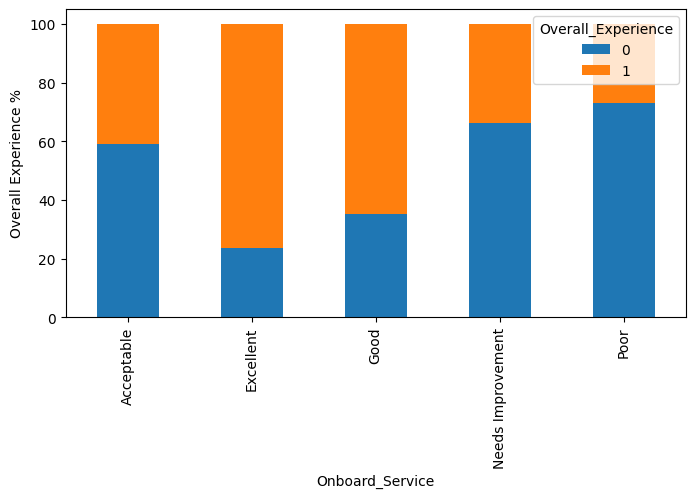

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Onboard Service)
 (pd.crosstab(train['Onboard_Service'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

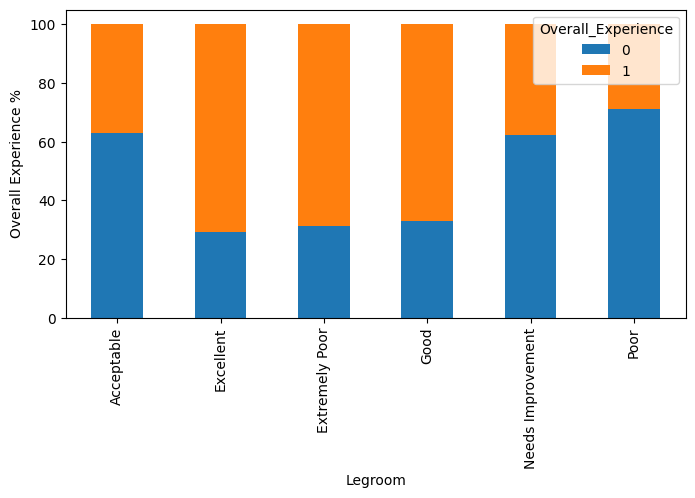

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Legroom)
 (pd.crosstab(train['Legroom'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

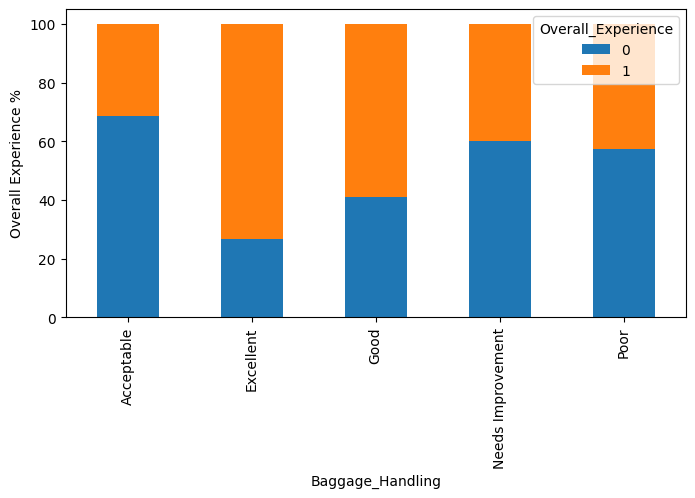

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Baggage Handling)
 (pd.crosstab(train['Baggage_Handling'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

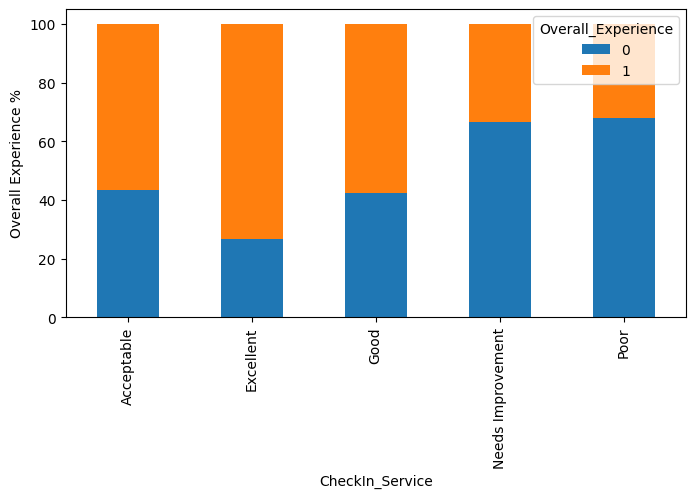

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(CheckIn Service)
 (pd.crosstab(train['CheckIn_Service'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

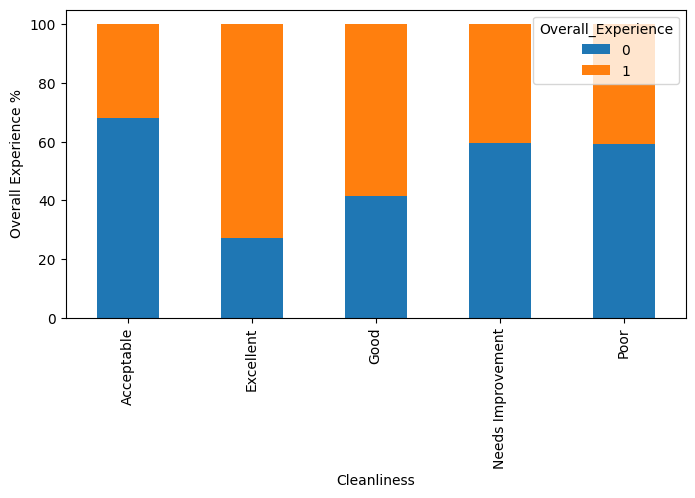

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Cleanliness)
 (pd.crosstab(train['Cleanliness'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

Text(0, 0.5, 'Overall Experience %')

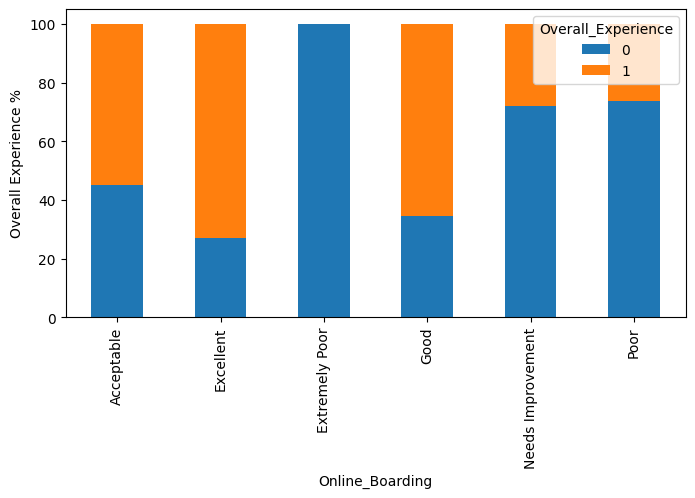

In [ ]:
# Check for relationship between target variable(Overall Experience) and categorical variable(Online Boarding)
 (pd.crosstab(train['Online_Boarding'],train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
plt.ylabel('Overall Experience %')

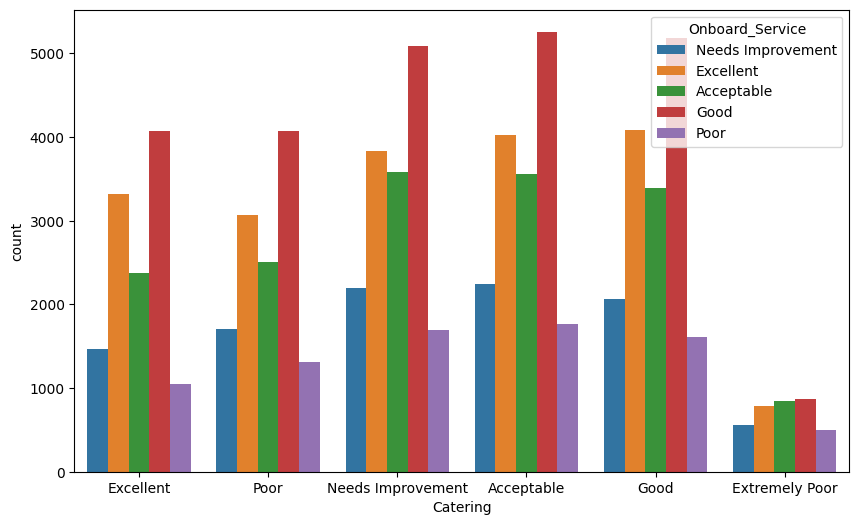

In [ ]:
# Check for difference in distribution of categorical variable(catering) by onboard service level
plt.figure(figsize = (10, 6))

sns.countplot(x = 'Catering', hue = 'Onboard_Service', data = train)

plt.show()

<a name="7"></a>
## 7. Data Preprocessing - Part2

### Let's find the percentage of outliers, in each column of the data, using IQR.

In [ ]:
Q1 = train.quantile(0.25)  # To find the 25th percentile and 75th percentile.
Q3 = train.quantile(0.75)

IQR = Q3 - Q1  # Inter Quantile Range (75th perentile - 25th percentile)

lower = (Q1 - 1.5 * IQR)  # Finding lower and upper bounds for all values. All values outside these bounds are outliers
upper = Q3 + 1.5 * IQR

In [ ]:
(
    (train.select_dtypes(include=["float64", "int64"]) < lower)
    | (train.select_dtypes(include=["float64", "int64"]) > upper)
).sum() / len(train) * 100

Age                        0.00000
Travel_Distance            2.04177
Departure_Delay_in_Mins   13.90775
Arrival_Delay_in_Mins     13.39281
Overall_Experience         0.00000
dtype: float64

### Missing Value Imputation

In [ ]:
train.isna().sum()

Gender                       77
Customer_Type              8951
Age                          33
Type_Travel                9226
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      57
Arrival_Delay_in_Mins       357
Overall_Experience            0
Seat_Comfort                 61
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location            30
Onboard_Wifi_Service         30
Onboard_Entertainment        18
Online_Support               91
Ease_of_Online_Booking       73
Onboard_Service            7601
Legroom                      90
Baggage_Handling            142
CheckIn_Service              77
Cleanliness                   6
Online_Boarding               6
dtype: int64

In [ ]:
# Columns to impute
reqd_col_for_impute = ["Gender", "Seat_Comfort", "Platform_Location","Onboard_Wifi_Service","Onboard_Entertainment","Online_Support","Ease_of_Online_Booking","Legroom","Baggage_Handling","CheckIn_Service","Cleanliness","Online_Boarding","Customer_Type","Type_Travel","Onboard_Service","Arrival_Time_Convenient"]

# Simple Imputer with Mode
imputer = SimpleImputer(strategy="most_frequent")

# Fit and transform the train data
train[reqd_col_for_impute] = imputer.fit_transform(train[reqd_col_for_impute])

# Transform the test data
test[reqd_col_for_impute] = imputer.transform(test[reqd_col_for_impute])

In [ ]:
# Columns to impute
reqd_col_for_impute = ["Age","Departure_Delay_in_Mins","Arrival_Delay_in_Mins"]

# Simple Imputer with Mode
imputer = SimpleImputer(strategy="mean")

# Fit and transform the train data
train[reqd_col_for_impute] = imputer.fit_transform(train[reqd_col_for_impute])

# Transform the test data
test[reqd_col_for_impute] = imputer.transform(test[reqd_col_for_impute])

In [ ]:
print(train.isna().sum())
print("-" * 30)
print(test.isna().sum())

Gender                        0
Customer_Type                 0
Age                           0
Type_Travel                   0
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins       0
Arrival_Delay_in_Mins         0
Overall_Experience            0
Seat_Comfort                  0
Seat_Class                    0
Arrival_Time_Convenient       0
Catering                   8741
Platform_Location             0
Onboard_Wifi_Service          0
Onboard_Entertainment         0
Online_Support                0
Ease_of_Online_Booking        0
Onboard_Service               0
Legroom                       0
Baggage_Handling              0
CheckIn_Service               0
Cleanliness                   0
Online_Boarding               0
dtype: int64
------------------------------
Gender                        0
Customer_Type                 0
Age                           0
Type_Travel                   0
Travel_Class                  0
Travel_Distance             

**Separating the independent variables (X) and the dependent variable (Y)**

In [ ]:
X = train.drop(["Overall_Experience"], axis=1)
y = train["Overall_Experience"]

### Encoding Categorical Variables

In [ ]:
# Creating dummy variables for the categorical columns
# drop_first=True is used to avoid redundant variables
X_train = pd.get_dummies(
    X,
    columns = X.select_dtypes(include = ["object", "category"]).columns.tolist(),
    drop_first = True,
)


# Creating dummy variables for the categorical columns
# drop_first=True is used to avoid redundant variables
X_test = pd.get_dummies(
    test,
    columns = test.select_dtypes(include = ["object", "category"]).columns.tolist(),
    drop_first = True,
)


In [ ]:
X_train

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Gender_Male,Customer_Type_Loyal Customer,Type_Travel_Personal Travel,Travel_Class_Eco,Seat_Comfort_Excellent,Seat_Comfort_Extremely Poor,Seat_Comfort_Good,Seat_Comfort_Needs Improvement,Seat_Comfort_Poor,Seat_Class_Ordinary,Arrival_Time_Convenient_Excellent,Arrival_Time_Convenient_Extremely Poor,Arrival_Time_Convenient_Good,Arrival_Time_Convenient_Needs Improvement,Arrival_Time_Convenient_Poor,Catering_Excellent,Catering_Extremely Poor,Catering_Good,Catering_Needs Improvement,Catering_Poor,Platform_Location_Inconvenient,Platform_Location_Manageable,Platform_Location_Needs Improvement,Platform_Location_Very Convenient,Onboard_Wifi_Service_Excellent,Onboard_Wifi_Service_Extremely Poor,Onboard_Wifi_Service_Good,Onboard_Wifi_Service_Needs Improvement,Onboard_Wifi_Service_Poor,Onboard_Entertainment_Excellent,Onboard_Entertainment_Extremely Poor,Onboard_Entertainment_Good,Onboard_Entertainment_Needs Improvement,Onboard_Entertainment_Poor,Online_Support_Excellent,Online_Support_Good,Online_Support_Needs Improvement,Online_Support_Poor,Ease_of_Online_Booking_Excellent,Ease_of_Online_Booking_Extremely Poor,Ease_of_Online_Booking_Good,Ease_of_Online_Booking_Needs Improvement,Ease_of_Online_Booking_Poor,Onboard_Service_Excellent,Onboard_Service_Good,Onboard_Service_Needs Improvement,Onboard_Service_Poor,Legroom_Excellent,Legroom_Extremely Poor,Legroom_Good,Legroom_Needs Improvement,Legroom_Poor,Baggage_Handling_Excellent,Baggage_Handling_Good,Baggage_Handling_Needs Improvement,Baggage_Handling_Poor,CheckIn_Service_Excellent,CheckIn_Service_Good,CheckIn_Service_Needs Improvement,CheckIn_Service_Poor,Cleanliness_Excellent,Cleanliness_Good,Cleanliness_Needs Improvement,Cleanliness_Poor,Online_Boarding_Excellent,Online_Boarding_Extremely Poor,Online_Boarding_Good,Online_Boarding_Needs Improvement,Online_Boarding_Poor
0,52.00000,272,0.00000,5.00000,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1
1,48.00000,2200,9.00000,0.00000,1,1,1,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0
2,43.00000,1061,77.00000,119.00000,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0
3,44.00000,780,13.00000,18.00000,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,50.00000,1981,0.00000,0.00000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94374,32.00000,1357,83.00000,125.00000,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
94375,44.00000,592,5.00000,11.00000,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
94376,63.00000,2794,0.00000,0.00000,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
94377,16.00000,2744,0.00000,0.00000,1,1,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0


In [ ]:
X_test

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Gender_Male,Customer_Type_Loyal Customer,Type_Travel_Personal Travel,Travel_Class_Eco,Seat_Comfort_Excellent,Seat_Comfort_Extremely Poor,Seat_Comfort_Good,Seat_Comfort_Needs Improvement,Seat_Comfort_Poor,Seat_Class_Ordinary,Arrival_Time_Convenient_Excellent,Arrival_Time_Convenient_Extremely Poor,Arrival_Time_Convenient_Good,Arrival_Time_Convenient_Needs Improvement,Arrival_Time_Convenient_Poor,Catering_Excellent,Catering_Extremely Poor,Catering_Good,Catering_Needs Improvement,Catering_Poor,Platform_Location_Inconvenient,Platform_Location_Manageable,Platform_Location_Needs Improvement,Platform_Location_Very Convenient,Onboard_Wifi_Service_Excellent,Onboard_Wifi_Service_Extremely Poor,Onboard_Wifi_Service_Good,Onboard_Wifi_Service_Needs Improvement,Onboard_Wifi_Service_Poor,Onboard_Entertainment_Excellent,Onboard_Entertainment_Extremely Poor,Onboard_Entertainment_Good,Onboard_Entertainment_Needs Improvement,Onboard_Entertainment_Poor,Online_Support_Excellent,Online_Support_Good,Online_Support_Needs Improvement,Online_Support_Poor,Ease_of_Online_Booking_Excellent,Ease_of_Online_Booking_Extremely Poor,Ease_of_Online_Booking_Good,Ease_of_Online_Booking_Needs Improvement,Ease_of_Online_Booking_Poor,Onboard_Service_Excellent,Onboard_Service_Good,Onboard_Service_Needs Improvement,Onboard_Service_Poor,Legroom_Excellent,Legroom_Extremely Poor,Legroom_Good,Legroom_Needs Improvement,Legroom_Poor,Baggage_Handling_Excellent,Baggage_Handling_Good,Baggage_Handling_Needs Improvement,Baggage_Handling_Poor,CheckIn_Service_Excellent,CheckIn_Service_Good,CheckIn_Service_Needs Improvement,CheckIn_Service_Poor,Cleanliness_Excellent,Cleanliness_Good,Cleanliness_Needs Improvement,Cleanliness_Poor,Online_Boarding_Excellent,Online_Boarding_Extremely Poor,Online_Boarding_Good,Online_Boarding_Needs Improvement,Online_Boarding_Poor
0,36.00000,532,0.00000,0.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
1,21.00000,1425,9.00000,28.00000,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,60.00000,2832,0.00000,0.00000,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0
3,29.00000,1352,0.00000,0.00000,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
4,18.00000,1610,17.00000,0.00000,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35597,8.00000,1334,0.00000,0.00000,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
35598,53.00000,1772,0.00000,0.00000,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
35599,22.00000,1180,0.00000,0.00000,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0
35600,67.00000,420,23.00000,16.00000,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


<a name="8"></a>
## 8. Model Evaluation Criterion

In [ ]:
# Creating metric function

def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Satisfied', 'Satisfied'], yticklabels=['Not Satisfied', 'Satisfied'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

<a name="9"></a>
## 9. Building the Model

<a name="9.1"></a>
### 9.1. Logistic Regression Model

In [ ]:
# Fitting logistic regression model
lg = LogisticRegression()
lg.fit(X_train,y)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     42786
           1       0.88      0.90      0.89     51593

    accuracy                           0.88     94379
   macro avg       0.88      0.87      0.88     94379
weighted avg       0.88      0.88      0.88     94379



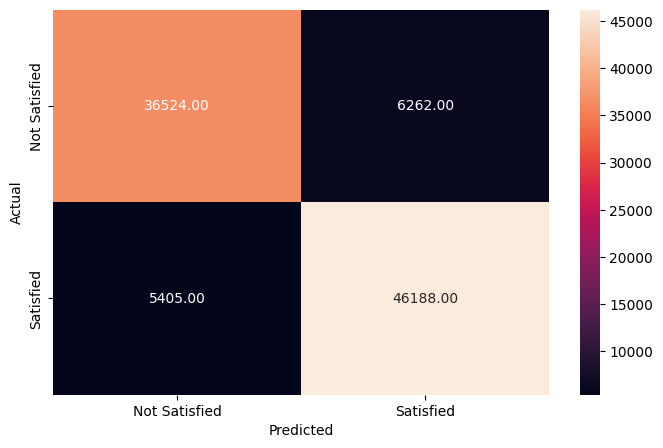

In [ ]:
# Checking the performance on the training data

y_pred_train = lg.predict(X_train)

metrics_score(y, y_pred_train)

In [ ]:
# Understand the relative importance of features in a trained model

cols=X_train.columns # Retrieve column names from the training features

coef_lg=lg.coef_ # Extract model coefficients from the trained model (assuming 'lg' is a model with 'coef_' attribute)

pd.DataFrame(coef_lg,columns=cols).T.sort_values(by=0,ascending=False) # Create a DataFrame with feature names as columns and coefficients as values

,0
Onboard_Entertainment_Excellent,2.76882
Seat_Comfort_Excellent,2.18854
Customer_Type_Loyal Customer,1.79846
Seat_Comfort_Extremely Poor,1.39246
Onboard_Entertainment_Good,1.35449
Catering_Extremely Poor,0.89893
Ease_of_Online_Booking_Good,0.85587
Catering_Excellent,0.79532
Online_Support_Excellent,0.75067
Onboard_Service_Excellent,0.72500


In [ ]:
# Generate predictions on the test set using the trained model
y_pred_test = lg.predict(X_test)
y_pred_test

array([1, 0, 1, ..., 0, 1, 0])

In [ ]:
# Create a DataFrame with the predicted values
column_names = ['Overall_Experience']
df = pd.DataFrame(y_pred_test, columns=column_names )
df

,Overall_Experience
0,1
1,0
2,1
3,0
4,1
...,...
35597,0
35598,1
35599,0
35600,1


In [ ]:
# Saving predictions as a CSV file
csv_file_path = 'prediction1.csv'
df.to_csv(csv_file_path, index=False)

In [ ]:
# Build the regression model and cross-validate
lg = LogisticRegression() # Create a Logistic Regression model instance
cv_Score11 = cross_val_score(lg, X_train, y, cv = 3) # Perform cross-validation with default scoring (accuracy)
cv_Score12 = cross_val_score(lg, X_train, y, cv = 3, scoring = 'accuracy') # Perform cross-validation explicitly specifying accuracy as the scoring metric

In [ ]:
cv_Score11

array([0.86198347, 0.85969485, 0.86242411])

In [ ]:
cv_Score12

array([0.86198347, 0.85969485, 0.86242411])

**Accuracy on Test Data: 0.8745576**

<a name="9.2"></a>
### 9.2. Random Forest Model

In [ ]:
# Fitting Random Forest model
rf_estimator = RandomForestClassifier(random_state = 1)

rf_estimator.fit(X_train, y)

RandomForestClassifier(random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42786
           1       1.00      1.00      1.00     51593

    accuracy                           1.00     94379
   macro avg       1.00      1.00      1.00     94379
weighted avg       1.00      1.00      1.00     94379



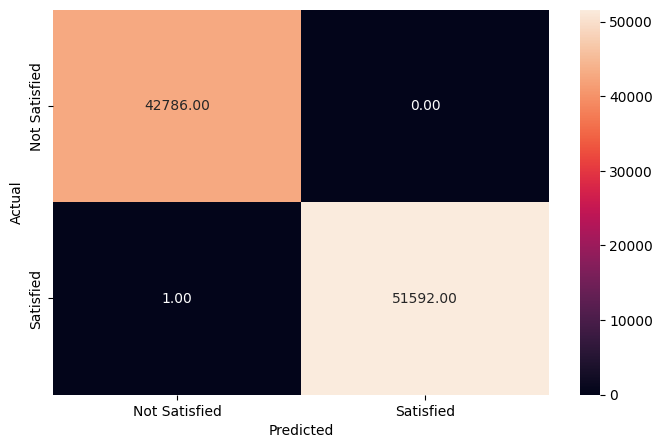

In [ ]:
# Checking the performance on the training data
y_pred_train_rf = rf_estimator.predict(X_train)

metrics_score(y, y_pred_train_rf)

In [ ]:

rf_estimator1 = RandomForestClassifier(random_state = 1) # Create a Random Forest classifier instance

cv_Score11 = cross_val_score(rf_estimator1, X_train, y, cv = 3) # Perform cross-validation with default scoring (accuracy)
cv_Score12 = cross_val_score(rf_estimator1, X_train, y, cv = 3, scoring = 'accuracy') # Perform cross-validation explicitly specifying accuracy as the scoring metric

In [ ]:
cv_Score11

array([0.94787031, 0.94809282, 0.94917194])

In [ ]:
cv_Score12

array([0.94787031, 0.94809282, 0.94917194])

In [ ]:
rf_estimator1.fit(X_train, y) # Fitting Random Forest Model

RandomForestClassifier(random_state=1)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42786
           1       1.00      1.00      1.00     51593

    accuracy                           1.00     94379
   macro avg       1.00      1.00      1.00     94379
weighted avg       1.00      1.00      1.00     94379



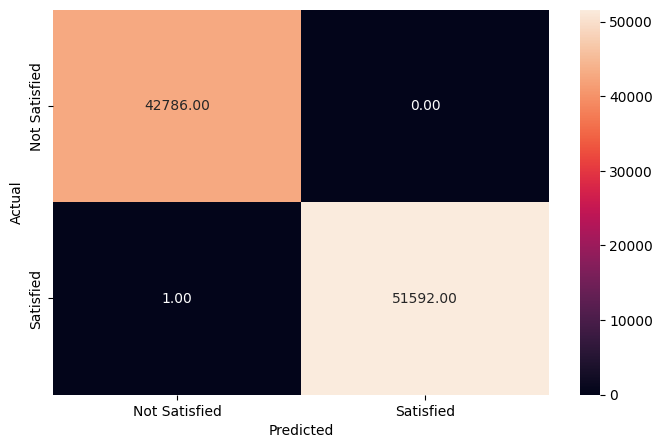

In [ ]:
# Checking the performance on the training data

y_pred_train_rf1 = rf_estimator1.predict(X_train)

metrics_score(y, y_pred_train_rf1)

In [ ]:
# Generate predictions on the test set using the trained model
y_pred_test_rf1 = rf_estimator1.predict(X_test)
y_pred_test_rf1

array([1, 1, 1, ..., 0, 1, 0])

In [ ]:
# Create a DataFrame with the predicted values
column_names = ['Overall_Experience']
df1 = pd.DataFrame(y_pred_test_rf1, columns=column_names )
df1

,Overall_Experience
0,1
1,1
2,1
3,0
4,1
...,...
35597,0
35598,1
35599,0
35600,1


In [ ]:
# Saving predictions as a CSV file
csv_file_path = 'prediction2.csv'
df1.to_csv(csv_file_path, index=False)

**Accuracy on Test Data: 0.9505084**

<a name="9.3"></a>
### 9.3. Random Forest Tuned Model

In [ ]:
# Performer Hypertuning on Random Forest Model
# Choose the type of classifier
rf_estimator_tuned = RandomForestClassifier( random_state = 7)

# Grid of parameters to choose from
parameters = {"n_estimators": [100, 150],
    "max_depth": [5,10,15],
    "min_samples_leaf": [2,4],
    "max_features": [0.8, 0.9],
    "max_samples": [0.9, 1]
    #"class_weight" : ["balanced",{0: 0.3, 1: 0.7}]
             }


# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring = 'accuracy', cv = 3)

grid_obj = grid_obj.fit(X_train, y)

# Set the classifier to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

In [ ]:
rf_estimator_tuned.fit(X_train, y) # Fitting Random Forest Tuned Model

RandomForestClassifier(max_depth=15, max_features=0.8, max_samples=0.9,
                       min_samples_leaf=2, n_estimators=150, random_state=7)

In [ ]:
# Generate predictions on the test set using the trained model
y_pred_test_rf_tuned = rf_estimator_tuned.predict(X_test)
y_pred_test_rf_tuned

array([1, 1, 1, ..., 0, 1, 0])

In [ ]:
# Create a DataFrame with the predicted values
column_names = ['Overall_Experience']
df3 = pd.DataFrame(y_pred_test_rf_tuned, columns=column_names )
df3

,Overall_Experience
0,1
1,1
2,1
3,0
4,1
...,...
35597,0
35598,1
35599,0
35600,1


In [ ]:
# Saving predictions as a CSV file
csv_file_path = 'prediction3.csv'
df3.to_csv(csv_file_path, index=False)

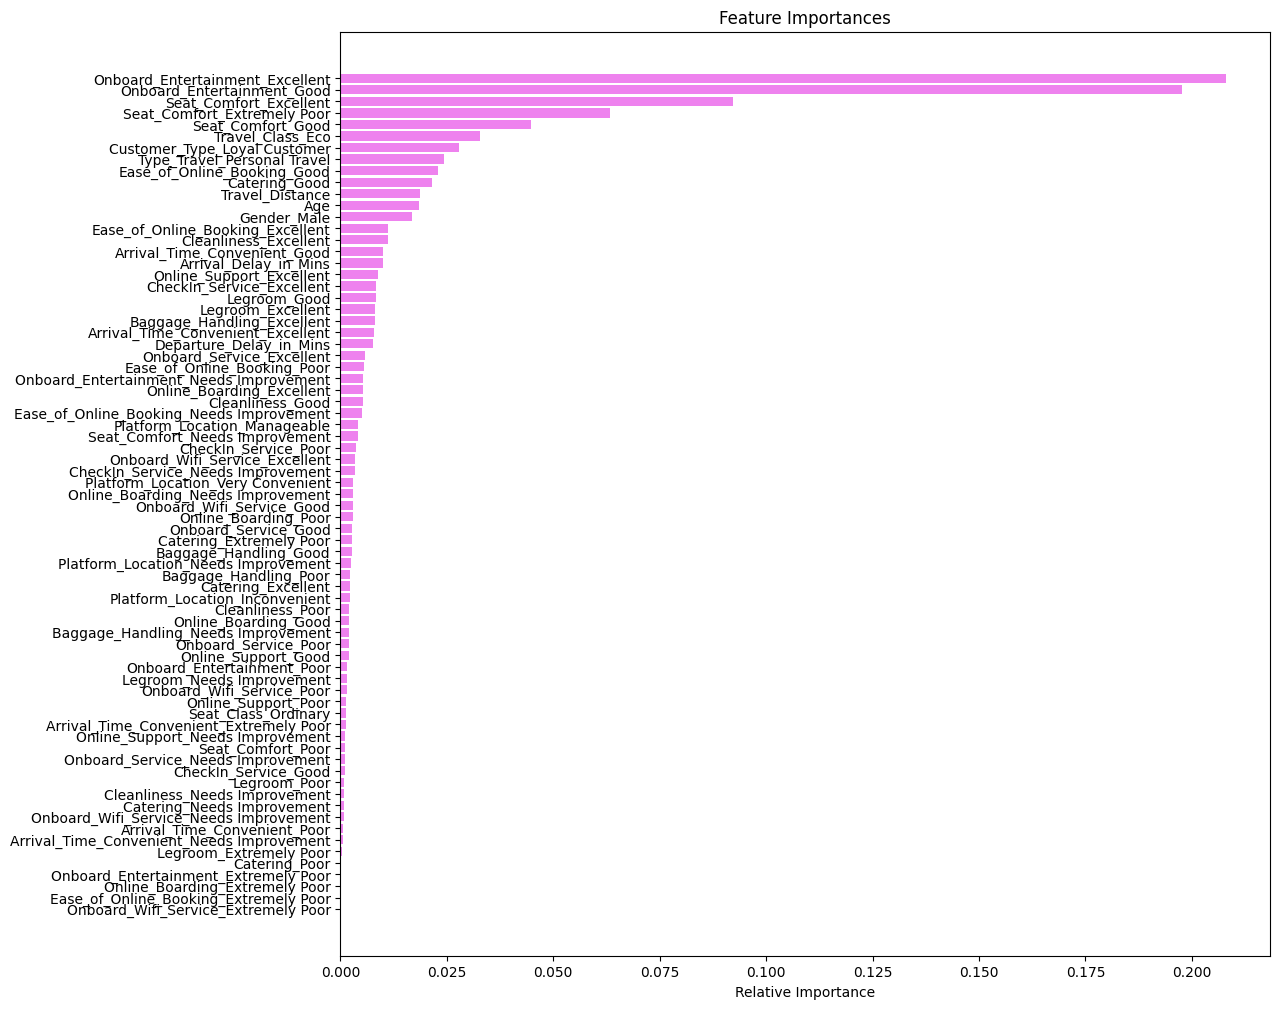

In [ ]:
importances = rf_estimator_tuned.feature_importances_ # Extracting Feature Importances

indices = np.argsort(importances) # Sorting Importances:

feature_names = list(X_train.columns) # Retrieving Feature Names

# Creating Visualization

plt.figure(figsize = (12, 12))

plt.title('Feature Importances')

plt.barh(range(len(indices)), importances[indices], color = 'violet', align = 'center')

plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

plt.xlabel('Relative Importance')

plt.show()

**Accuracy on Test Data: 0.9470254**

<a name="9.4"></a>
### 9.4. LightGBM Model

In [ ]:
# Create a LightGBM classifier with class imbalance handling
lgb.LGBMClassifier(is_unbalance=True)

LGBMClassifier(is_unbalance=True)

In [ ]:
gbm = lgb.LGBMClassifier(is_unbalance=True)
gbm.fit(X_train, y) # Fit the model to the training data
y_pred_lgbm = gbm.predict(X_test) # Make predictions on the test data
scores = gbm.predict_proba(X_test) # Get predicted probabilities for each class
print(y_pred_lgbm.mean()) # Print the mean of the predicted values (not very informative for binary classification)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 51593, number of negative: 42786
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 94379, number of used features: 71
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546658 -> initscore=0.187175
[LightGBM] [Info] Start training from score 0.187175
0.5333689118588844


In [ ]:
# Create a DataFrame with the predicted values
column_names = ['Overall_Experience']
df4 = pd.DataFrame(y_pred_lgbm, columns=column_names )
df4

,Overall_Experience
0,1
1,1
2,1
3,0
4,1
...,...
35597,0
35598,1
35599,1
35600,1


In [ ]:
# Saving predictions as a CSV file
csv_file_path = 'prediction3.csv'
df4.to_csv(csv_file_path, index=False)

**Accuracy on Test Data: 0.9470254**